# Matrix factorization and song recommendation
***
A common approach for collaborative filtering is matrix factorization, where we decompose the full matrix of playlist-track contingency into product of low rank matrices. Each playlist and track is represented into a lower dimensional latent factor space, and the product of the matrices approximates the original data. Here was use singular value decomposition (SVD) to perform matrix factorization on a subset of data consisting of randomly selected 10,000 playlists, and made song recommendation based on the reconstructed matrix. The quality of recommendation was then judged by the Jaccard index between recommended songs and existing songs in a given playlist.
***
First we load all the libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
import scipy.sparse as sps
from scipy.sparse.linalg import svds
import scipy
import pickle

sns.set()
%matplotlib inline

## Load data 

***
Here we loaded the sparse matrix containing track-playlist contingency.

In [2]:
# load files
sps_acc = scipy.sparse.load_npz('sparse_10000_rand.npz')
n_tracks, n_playlists = sps_acc.shape[0], sps_acc.shape[1]
sps_acc = sps_acc.tocsr()
sps_acc

<171381x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 657056 stored elements in Compressed Sparse Row format>

## Explore number of latent factors
***
We used ***truncatedSVD*** from sklearn to explore the explained variance ratio with different number of latent factors.

In [67]:
# Perform truncated SVD
n_comp_list = [10,20,30,50,75,100,150,200,250,300,350,400,450,500]
explain_var = []
for n_comp in n_comp_list:
    svd = TruncatedSVD(n_components=n_comp, algorithm ='arpack')
    svd.fit(sps_acc.transpose())  
    explain_var.append(svd.explained_variance_ratio_.sum())

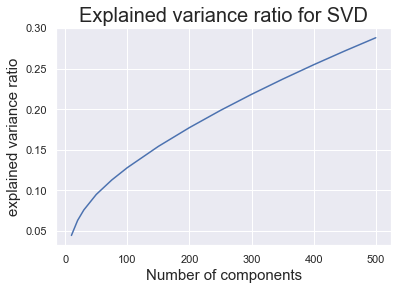

In [12]:
# plot explained variance ratio 
plt.plot(n_comp_list,explain_var)
plt.xlabel('Number of components',fontsize = 15)
plt.ylabel('explained variance ratio',fontsize = 15)
plt.title('Explained variance ratio for SVD',fontsize = 20);

As we can see from the plot, as we increased the number of latent factors, the explained variance ratio increased. With 500 latent factors, the decomposed matrices can explain slightly less than 30% of the variance.

## Make song recommendation with SVD
***
Here we chose 500 latent factors, and made song recommendation with the reconstructed playlist-track matrix. We used ***svds*** from Scipy.Sparse library since it returned the decomposed matrices as well as the singular values. Then for a given playlist, we obtain the estimated "scores" of the track profile, and made recommendation on the tracks with high score but weren't in the playlist.

Here are some functions we defined for making recommendation, generate track pairs from list of playlists, and calculate Jaccard index.

- ***recommend_tracks_SVD***
This function makes recommendation of tracks that are not currently in a specific playlist. It returns the list of tracks that weren't in the playlist, sorted by the scores in the reconstructed matrix (from high to low).

- ***get_jaccard***
This function calculated the Jaccard index between a pair of tracks.

- ***create_unique_pair_subset*** and ***create_pairs_btw_lists*** help creating pairs of tracks from given lists.

In [4]:
# use SVD in scipy 
n_comps = 500
u, s, vt = svds(sps_acc, k=n_comps)

As we can see, the singular values dropped rapidly between from 1-50 latent factors.

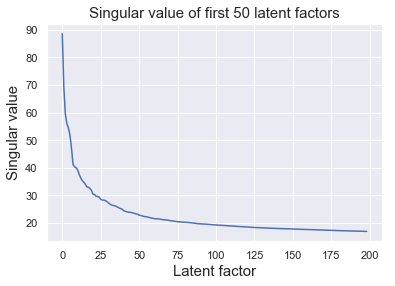

In [66]:
# plot first 200 singular values
plt.plot(s[-1:-200:-1])
plt.xlabel('Latent factor', fontsize = 15)
plt.ylabel('Singular value', fontsize = 15)
plt.title('Singular value of first 50 latent factors', fontsize = 15);

In [6]:
sv_mat = np.diag(s)
track_mat = np.dot(u,sv_mat)

print('Shape of u =', u.shape,
     '\nShape of sv_mat = ', sv_mat.shape,
     '\nShape of vt =', vt.shape)

Shape of u = (171381, 500) 
Shape of sv_mat =  (500, 500) 
Shape of vt = (500, 10000)


In [7]:
# this function returns the indices and scores for recommeded tracks given a playlist_id
def recommend_tracks_SVD(sps_acc, playlist_ind, track_mat, vt):
    pid = playlist_ind

    # make prediction with the SVD model
    scores = np.dot(track_mat,vt[:,pid])

    # extract real class label from original data
    real_class = np.array(sps_acc[:,pid].toarray()).reshape(-1,)
    
    # real tracks: real class one
    real_one_ind = np.argwhere(real_class==1).reshape(-1,)
    real_zero_ind = np.argwhere(real_class==0).reshape(-1,)
    
    # sort the real zero samples by the score (from highest to lowest)
    recom_scores = scores[real_zero_ind]
    recom_sort_ind = np.argsort(recom_scores)
    recom_ind = real_zero_ind[recom_sort_ind[::-1]]
    recom_scores_sort = recom_scores[recom_sort_ind[::-1]]

    return recom_ind, recom_scores_sort, real_one_ind

In [8]:
# this function return jaccard index between a pair of tracks
def get_jaccard(sps_acc, pair):
    pair = list(pair)
    track1 = pair[0]
    track2 = pair[1]

    mem = np.array(sps_acc[pair,:].toarray())

    mem1 = np.argwhere(mem[0,:]).reshape(-1,)
    mem2 = np.argwhere(mem[1,:]).reshape(-1,)

    intersect = list(set(mem1) & set(mem2))
    union = list(set(mem1) | set(mem2))
    jaccard = len(intersect)/len(union)
    
    return jaccard

In [9]:
# this function creates a subset of unique pair of a given list of tracks
def create_unique_pair_subset(track_list, num):
    track_list = list(track_list)
    track_pairs = [(track1, track2) for i, track1 in enumerate(track_list) 
               for j, track2 in enumerate(track_list) if i<j]
    total_num = len(track_pairs)
    if total_num > num:
        sub_ind = list(np.random.choice(total_num, num, replace=False))
        track_pair_subset = [pair for idx, pair in enumerate(track_pairs) if idx in sub_ind]
    else:
        track_pair_subset = track_pairs
    
    return track_pair_subset

In [10]:
# this function creates all pairs between 2 given lists of tracks
def create_pairs_btw_lists(track_list1, track_list2):
    track_list1 = list(track_list1)
    track_list2 = list(track_list2)
    track_pairs = [(track1, track2) for track1 in track_list1 for track2 in track_list2]
    return track_pairs

## Make recommendation for one playlist
***
Here we randomly selected a playlist, and made recommendation of the top 10 songs with the highest scores. We then computed Jaccard index between the recommended songs and existing songs (***rec vs. real***), and compared that to Jaccard index between exisitng songs (***btw real***), and Jaccard index between exisitng songs and 10 randomly selected songs not were not recommended (***not-rec vs. real***). Jaccard inex for ***Rrandom pairs*** of tracks was also computed as baseline.

In [73]:
# randomly select one playlist and make recommendation
playlist_id = np.random.choice(n_playlists, 1)[0]

# number of recommended tracks
num_rec = 10

# get recommendation from NN model
rec_ind, _, real = recommend_tracks_SVD(sps_acc, playlist_id, track_mat, vt)

# restrict number of real tracks to no more than 50
if real.shape[0] > 50:
    real = real[np.random.choice(real.shape[0], 50, replace=False)]

# select rec
rec = rec_ind[:num_rec]
# randomly pick num_rec as not-rec, but not the ones that are rec
not_rec = rec_ind[np.random.choice(rec_ind.shape[0]-num_rec, num_rec, replace=False)+num_rec] 

# calculate the pair number
pair_num = real.shape[0]*num_rec

# collect jaccard index for rec-real pairs
rec_real_pairs = create_pairs_btw_lists(rec, real)
rec_real_jac = [get_jaccard(sps_acc,i) for i in rec_real_pairs]

# collect jaccard index for real-real pairs
real_real_pairs = create_unique_pair_subset(real, pair_num)
real_real_jac = [get_jaccard(sps_acc,i) for i in real_real_pairs]

# collect jaccard index for not_rec-real pairs
not_rec_real_pairs = create_pairs_btw_lists(not_rec, real)
not_rec_real_jac = [get_jaccard(sps_acc,i) for i in not_rec_real_pairs]

# random pairs
rand_pair_num = 100
rand_id = list(np.random.choice(n_tracks, 2*rand_pair_num))
rand_pairs = [(tr1,tr2) for tr1 in rand_id[:rand_pair_num] 
              for tr2 in rand_id[rand_pair_num+1:] if tr1<tr2]
rand_jac = [get_jaccard(sps_acc,i) for i in rand_pairs]

print('Mean Jaccard index\n rec vs. real =',np.mean(rec_real_jac),
      '\n btw real =',np.mean(real_real_jac),
      '\n not_rec vs. real',np.mean(not_rec_real_jac),
      '\n random pair',np.mean(rand_jac))

Mean Jaccard index
 rec vs. real = 0.009245493911145377 
 btw real = 0.11331664265473237 
 not_rec vs. real 0.00019028172967485926 
 random pair 0.00018542653802965727


### Visualize result
***
We can visualize the distribution of Jaccard index of 4 groups by plotting their empirical cumulative density functions. As we can see here, the ***btw real*** have distributions of highest Jaccard index, meaning that the tracks are similar to each other. The ***rec vs. real*** had intermediate Jaccard index, whereas the Jaccard index for ***not-rec vs. real*** group was really close to zero, comparable to ***random pairs*** of tracks. Therefore, the recommendation seems to be working at some degree, making recommendation of songs that were at some degree similar to the existing songs.

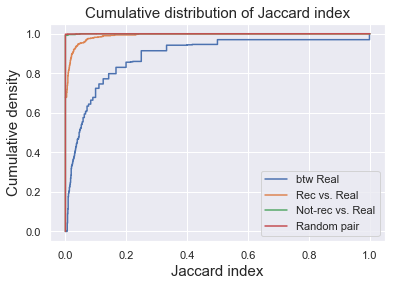

In [74]:
# visualize distribution of Jaccard index
import statsmodels.api as sm
import itertools
ecdf1 = sm.distributions.ECDF(real_real_jac)
x1 = np.linspace(0, max(real_real_jac),1000)
y1 = ecdf1(x1)
plt.step(x1, y1,label='btw Real')

ecdf2 = sm.distributions.ECDF(rec_real_jac)
y2 = ecdf2(x1)
plt.step(x1, y2,label='Rec vs. Real')

ecdf3 = sm.distributions.ECDF(not_rec_real_jac)
x3 = np.linspace(0, max(real_real_jac),10000)
y3 = ecdf3(x3)
plt.step(np.concatenate((np.zeros(1,),x3)), np.concatenate((np.zeros(1,),y3)),label='Not-rec vs. Real')

ecdf4 = sm.distributions.ECDF(rand_jac)
y4 = ecdf4(x3)
plt.step(np.concatenate((np.zeros(1,),x3)), np.concatenate((np.zeros(1,),y4)),label='Random pair')

plt.legend(loc='best')
plt.title('Cumulative distribution of Jaccard index',fontsize = 15)
plt.xlabel('Jaccard index',fontsize = 15)
plt.ylabel('Cumulative density',fontsize = 15);

## Scale up for 100 playlists
***
We can scale up our recommendation to 100 randomly selected playlists and look at the statistics of the Jaccard index of each group.

In [15]:
# randomly select 100 playlists
playlist_subset = np.random.choice(n_playlists, 100, replace = False)

# create empty lists
mean_rec_real_jac = []
mean_real_real_jac = []
mean_not_rec_real_jac = []
mean_rand_jac = []

In [22]:
# loop over playlist subset to get jaccard index
for ii, playlist_id in enumerate(playlist_subset):
    # specify number of recommendation (=10 songs)
    num_rec = 10
    
    # get recommendation from NN model
    rec_ind, _, real = recommend_tracks_SVD(sps_acc, playlist_id, track_mat, vt)

    # restrict number of real tracks to no more than 50
    if real.shape[0] > 50:
        real = real[np.random.choice(real.shape[0], 50, replace=False)]

    # select rec
    rec = rec_ind[:num_rec]
    # randomly pick num_rec as not-rec, but not the ones that are rec
    not_rec = rec_ind[np.random.choice(rec_ind.shape[0]-num_rec, num_rec, replace=False)+num_rec] 
    
    # calculate the pair number
    pair_num = real.shape[0]*num_rec

    # collect jaccard index for rec-real pairs
    rec_real_pairs = create_pairs_btw_lists(rec, real)
    rec_real_jac = [get_jaccard(sps_acc,i) for i in rec_real_pairs]
    mean_rec_real_jac.append(np.mean(rec_real_jac))

    # collect jaccard index for real-real pairs
    real_real_pairs = create_unique_pair_subset(real, pair_num)
    real_real_jac = [get_jaccard(sps_acc,i) for i in real_real_pairs]
    mean_real_real_jac.append(np.mean(real_real_jac))

    # collect jaccard index for not_rec-real pairs
    not_rec_real_pairs = create_pairs_btw_lists(not_rec, real)
    not_rec_real_jac = [get_jaccard(sps_acc,i) for i in not_rec_real_pairs]
    mean_not_rec_real_jac.append(np.mean(not_rec_real_jac))
    
    # random pairs
    rand_pair_num = 100
    rand_id = list(np.random.choice(n_tracks, 2*rand_pair_num))
    rand_pairs = [(tr1,tr2) for tr1 in rand_id[:rand_pair_num] 
                  for tr2 in rand_id[rand_pair_num+1:] if tr1<tr2]
    rand_jac = [get_jaccard(sps_acc,i) for i in rand_pairs]
    mean_rand_jac.append(np.mean(rand_jac))

In [21]:
# put result into a dict
jaccard_dict = {}
jaccard_dict['rec_real'] = mean_rec_real_jac
jaccard_dict['real_real'] = mean_real_real_jac
jaccard_dict['not_rec_real'] = mean_not_rec_real_jac
jaccard_dict['rand_pair'] = mean_rand_jac

### Visualization 
***
The boxplot below shows the distribution of mean Jaccard index of the 4 groups for the 100 playlists. The ***btw real*** group had the highest Jaccard index, meaning they were similar to eacxh other. The ***rec vs. real*** had intermediate Jaccard index, indicating that the recommended songs were somewhat similar to the existing songs. Jaccard index for ***not-rec vs. real group*** was near zero, showing low similarity to the exisiting songs (as ***random pairs*** of tracks). 

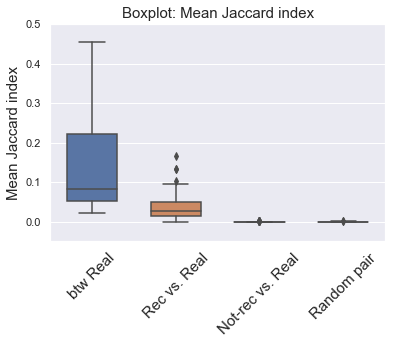

In [65]:
# result visualization

# put results into dataframe
all_jac = np.concatenate((np.array(mean_real_real_jac),
                          np.array(mean_rec_real_jac),
                          np.array(mean_not_rec_real_jac),
                          np.array(mean_rand_jac)))
label = np.concatenate((np.ones(100,),np.ones(100,)*2,
                        np.ones(100,)*3,np.ones(100,)*4))
jac_df = pd.DataFrame({'jac':all_jac, 'label': label})

# plot boxplot
ax = sns.boxplot(x='label', y='jac', data=jac_df,width = 0.6)
plt.xticks([0.,1.,2.,3.], ['btw Real','Rec vs. Real','Not-rec vs. Real','Random pair'],fontsize = 15, rotation=45)
plt.ylim([-0.05, 0.5])
plt.title('Boxplot: Mean Jaccard index',fontsize = 15)
plt.xlabel('')
plt.ylabel('Mean Jaccard index',fontsize = 15);

## Further on number of latent factors
***
We also performed SVD with different number of latent factors and invetigated the song recommendation using different models.

In [25]:
# SVD with different number of latent factors and compute Jaccaed index for recommendation
n_comps = [5, 10, 20, 50, 100, 200]
all_rec_real_jac = {}

for n in n_comps:
    u, s, vt = svds(sps_acc, k=n)
    sv_mat = np.diag(s)
    track_mat = np.dot(u,sv_mat)
    
    mean_rec_real_jac = []    
    for ii, playlist_id in enumerate(playlist_subset):
        # specify number of recommendation (=10 songs)
        num_rec = 10

        # get recommendation from NN model
        rec_ind, _, real = recommend_tracks_SVD(sps_acc, playlist_id, track_mat, vt)

        # restrict number of real tracks to no more than 50
        if real.shape[0] > 50:
            real = real[np.random.choice(real.shape[0], 50, replace=False)]

        # select rec
        rec = rec_ind[:num_rec]

        # collect jaccard index for rec-real pairs
        rec_real_pairs = create_pairs_btw_lists(rec, real)
        rec_real_jac = [get_jaccard(sps_acc,i) for i in rec_real_pairs]
        mean_rec_real_jac.append(np.mean(rec_real_jac))
        
    all_rec_real_jac[n] = mean_rec_real_jac

all_rec_real_jac[500] = jaccard_dict['rec_real']

### Visualization and comparison between models
***
As we increased the number of latent factors, the mean Jaccard index between the recommended songs and exisitng songs increased.

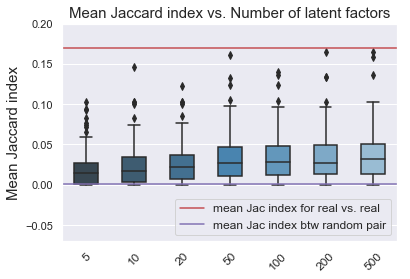

In [78]:
# put results into dataframe
all_jac = np.concatenate(([np.array(val) for val in all_rec_real_jac.values()]))
label = np.concatenate(([np.ones(100,)*key for key in all_rec_real_jac.keys()]))
jac_df = pd.DataFrame({'jac':all_jac, 'label': label})

# plot boxplot
ax = sns.boxplot(x='label', y='jac', data=jac_df, width = 0.5, palette = "Blues_d")
plt.axhline(y = np.mean(mean_real_real_jac),color='r',label='mean Jac index for real vs. real')
plt.axhline(y = np.mean(mean_rand_jac),color='m',label='mean Jac index btw random pair')
plt.xticks(np.arange(7), [int(key) for key in all_rec_real_jac.keys()], fontsize = 12, rotation=45)
plt.ylim([-0.07, 0.2])
plt.legend(loc=4, fontsize = 12)
plt.title('Mean Jaccard index vs. Number of latent factors',fontsize = 15)
plt.xlabel('')
plt.ylabel('Mean Jaccard index', fontsize = 15);

In [63]:
# save results
with open('jaccard_100_playlists_SVD_rand.pkl','wb') as f0:
    pickle.dump(jaccard_dict, f0)
with open('playlist_id_100_for_jaccard_SVD_rand.pkl','wb') as f1:
    pickle.dump(playlist_subset, f1)
with open('jaccard_latent_factors_SVD_rand.pkl','wb') as f2:
    pickle.dump(all_rec_real_jac, f2)

## Extra visualization: tracks in tSNE embedding
***
We can play with the data a little bit more by visualizing the tracks in SVD latent space using tSNE in 2D. We first performed SVD with 100 components.

In [100]:
# perform SVD with 100 latent components
n_comps = 100
svd = TruncatedSVD(n_components=n_comps, algorithm ='arpack')
svd.fit(sps_acc.transpose())
sin_mat = np.diag(svd.singular_values_)
feature = np.dot(svd.components_[:,::4].transpose(),sin_mat)

Then we fit tSNE with different values for perplexity.

In [101]:
# perform tSNE on tracks in the latent space
from sklearn.manifold import TSNE
perplex = [5.,15.,30.,50.,100.,200.]
X_embedding = {}
for per in perplex:
    print(per)
    this_embedding = TSNE(n_components=2, perplexity = per, verbose=1).fit_transform(feature)
    X_embedding[per] = this_embedding

Visualizing them: as the perplexity increased, we observed more clusters/sturctures in the plot.

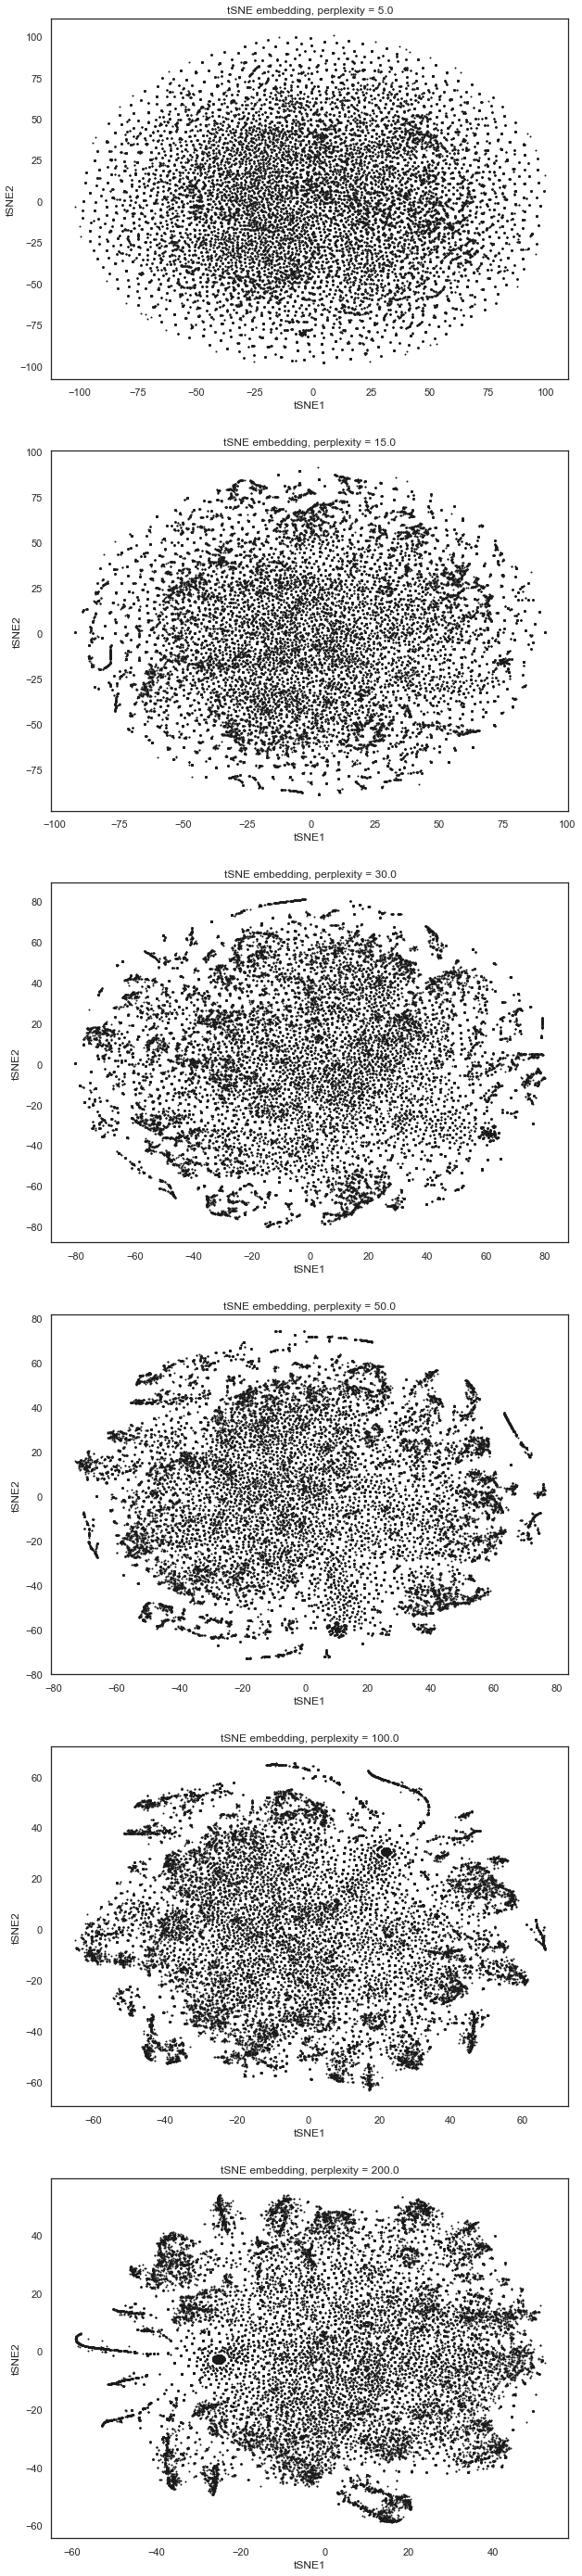

In [106]:
sns.set_style("white")
fig, axes = plt.subplots(6,1,figsize = (10,50))
i = 0
for key, val in X_embedding.items():
    x = val[:,0]
    y = val[:,1]
    axes[i].scatter(x,y,s=1,c='k');
    axes[i].set(xlabel = 'tSNE1', ylabel ='tSNE2', title = 'tSNE embedding, perplexity = {}'.format(key));
    i += 1

We can also plot tracks in several large playlists onto the tSNE plot. Sometimes songs within a playlist seemed to be clustered at some location, but sometimes they appeared to be spread out.

In [90]:
# sort playlists by size
playlist_size = np.array(sps_acc.sum(axis = 0)).reshape(-1,)
ordered_playlist = np.argsort(playlist_size)

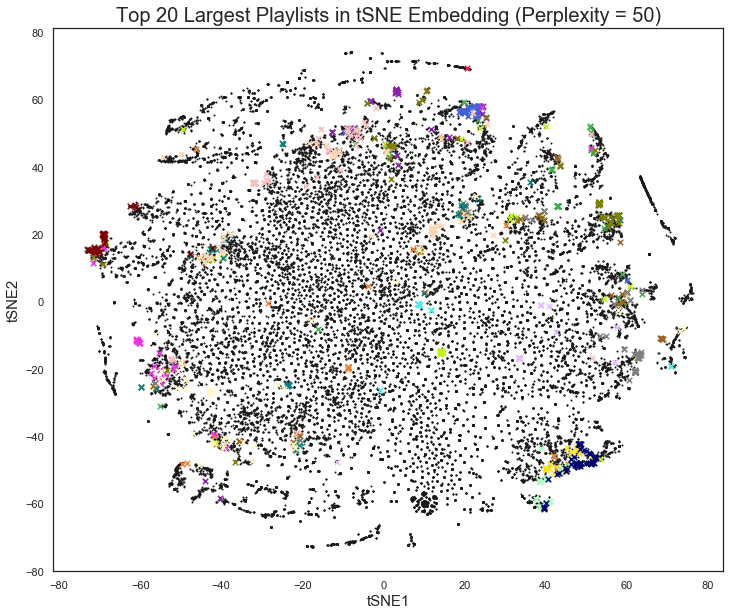

In [107]:
# plot 20 largest playlists onto tSNE embedding
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', 
          '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
          '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
          '#000075', '#808080', '#ffffff', '#000000']
fig, ax = plt.subplots(1,1,figsize = (12,10))
x = X_embedding[50][:,0]
y = X_embedding[50][:,1]
plt.scatter(x,y,s=1,c='k');
for i in range(20):
    this_playlist = np.array(sps_acc[:,ordered_playlist[-i]].toarray()).reshape(-1,).astype(int)
    idx = this_playlist[::4]
    plt.scatter(x[idx==1],y[idx==1],s=30,c=colors[i],marker = 'x')
plt.xlabel('tSNE1', fontsize = 15)
plt.ylabel('tSNE2', fontsize = 15)
plt.title('Top 20 Largest Playlists in tSNE Embedding (Perplexity = 50)',fontsize = 20);